In [1]:
import numpy as np
import pandas as pd

logistic = lambda x: 1 / (1 + np.exp(-x))
true_f = lambda X: logistic(-2 * X['race'] + X['sex'] + X['score'] / 5 - 2.2) >= .5

def gen_data(n):
  X1 = np.random.binomial(1, .5, n)
  X2 = np.random.binomial(1, .3, n)  # and try raising to 0.5 see how r switches -- incr var(X2) but r(X2) drops below r(X1)
  A = np.random.normal(6, 1, n)
  E = np.random.normal(1, 1, n)
  X3 = (A + E).clip(0,10).round()
  X = pd.DataFrame(np.vstack((X1, X2, X3)).T, columns=['race', 'sex', 'score'])
  Y = true_f(X)
  Z = logistic(X1 + 3 * X2 + X3 / 8 + E - 1.5) >= .5
  return pd.DataFrame(np.vstack((Y, Z)).T, columns=['admit', 'respond']).join(X)

N = 10000
apps = gen_data(N)
resps = apps.query('respond == 1')
EZ = apps.respond.mean()

In [2]:
print('Response rate:', round(EZ, 2))
print('Self-reported acceptance rate:', round(resps.admit.mean(), 2))
print('Number of responses: %d / %d' % (len(resps), N))

Response rate: 0.83
Self-reported acceptance rate: 0.16
Number of responses: 8278 / 10000


In [3]:
from sklearn.linear_model import LogisticRegression

Y = resps['admit']
X = resps[['race', 'sex', 'score']]
g1 = LogisticRegression().fit(X, resps.admit).predict
print('Logistic regression accuracy:', (g1(X) == resps.admit).mean())
g_min = lambda x: g1(x) * EZ
g_max = lambda x: g1(x) * EZ + (1 - EZ)

Logistic regression accuracy: 1.0


In [4]:
L = lambda y, y_hat: np.square(y - y_hat)
def categorical_loss(X, col):
  x1_cats = X[col].sort_values().unique()
  running_sums = 0
  running_sums_min = 0
  running_sums_max = 0
  for c in x1_cats:
    X_c = X.copy()
    X_c[col] = c
    losses = (L(Y, g_min(X_c)), L(Y, g_max(X_c)))
    min_L_c = np.minimum(*losses)
    L_c = L(Y, true_f(X_c) + 0.0)
    max_L_c = np.maximum(*losses)

    # whatever the mult is for this c -- if x1i = c then nc - 1 else nc
    m_c = pd.Series((X[col] == c).sum(), index=X.index)
    m_c.loc[X[col] == c] -= 1
    
    running_sums += (m_c * L_c).sum()
    running_sums_min += (m_c * min_L_c).sum()
    running_sums_max += (m_c * max_L_c).sum()
  
  n = len(X)
  avg_loss = 1 / (n * (n - 1)) * running_sums
  avg_loss_min = 1 / (n * (n - 1)) * running_sums_min
  avg_loss_max = 1 / (n * (n - 1)) * running_sums_max
  return avg_loss, avg_loss_min, avg_loss_max

In [5]:
labels = []
r_pt = []
r_range = [[], []]
for i, c in enumerate(X.columns):
  avg_loss, avg_loss_min, avg_loss_max = categorical_loss(X, c)
  labels.append(f'{c.capitalize()} (\$X_{i + 1}\$)')
  r_pt.append(avg_loss)
  # r_all
  # r_range[0].append(avg_loss - avg_loss_min * EZ)
  # r_range[1].append(avg_loss_max * EZ + (1 - EZ) - avg_loss)
  # r_admit
  r_range[0].append(avg_loss - avg_loss_min)
  r_range[1].append(avg_loss_max - avg_loss)
r_pt = np.array(r_pt)

(0.0, 0.24)

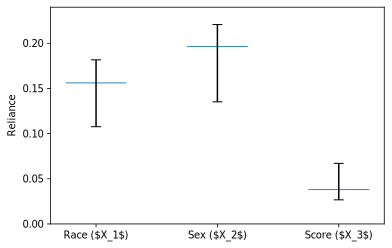

In [13]:
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none' # orig: path
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
fig = plt.figure()
ax = fig.add_subplot()
ax.bar(x=labels, height=0.001, bottom=r_pt, width=0.5, tick_label=labels, yerr=r_range, capsize=5)
# ax.bar(x=labels, height=0.001, bottom=r_pt, width=0.5, tick_label=labels, yerr=None, capsize=5)
# ax.set_title('Reliance for Responding Students (Z=1)')
ax.set_ylabel('Reliance')
ax.set_ylim([0, 0.24])
# ax.set_ylim([0, 0.44])